In [74]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
path_dataset = "data_train.csv"
ratings = load_data(path_dataset)
print('Shape of ratings matrix:',ratings.shape)

number of items: 10000, number of users: 1000
Shape of ratings matrix: (10000, 1000)


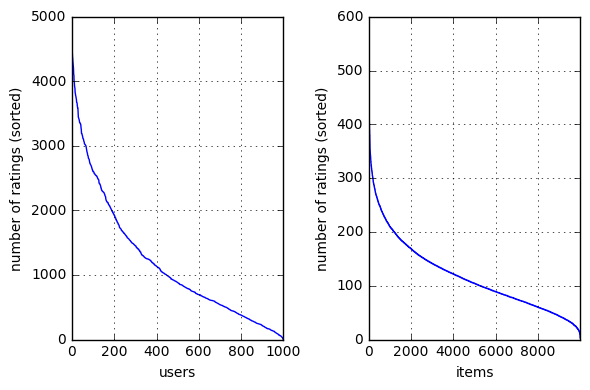

min # of items per user = 8, min # of users per item = 3.


In [76]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [77]:
def initialize_matrices_random(train, num_features):
    """
        Initialize randomly matrices W and Z of matrix factorization.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    item_features = np.random.random((train.shape[0], num_features)) # W matrix initialization
    user_features = np.random.random((train.shape[1], num_features)) # Z matrix initialization
    
    return item_features, user_features

In [78]:
def initialize_matrices_global_mean(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization such that W*Z^T contains global
        mean at all positions. Therefore all elements of W and Z equal to 
        square root of global_mean/num_features

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
            
    """
    global_mean = np.sum(train)/len(train.nonzero()[0])

    # W matrix initialization
    item_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[0], num_features)) 
    # Z matrix initialization
    user_features = np.sqrt(global_mean/num_features) * np.ones((train.shape[1], num_features))
    
    return item_features, user_features

In [79]:
def initialize_matrices_SVD(train, num_features):
    """
        Initialize matrices W and Z of matrix factorization using SVD decomposition of original matrix X.

        Arguments:
            train: training set (matrix X)
            num_features: number of latent variables in the W*Z^T decomposition

        Returned value(s):
            item_features: matrix W of shape = num_features, num_item
            user_features: matrix Z of shape = num_features, num_user
    """
    
    U, s, V = np.linalg.svd(train, full_matrices=False)
    
    S = np.diag(s)

    U_1 = U[:, 0:num_features]
    S_1 = S[0:num_features, 0:num_features]
    V_1 = V[0:num_features, :]
    
    item_features = U_1 # W matrix initialization
    user_features = (S_1.dot(V_1)).T # Z matrix initialization
    
    return item_features, user_features

In [80]:
def find_bias_vectors(ratings):
    # calculating the user_bias and item_bias vectors:

    global_mean = np.sum(ratings)/len(ratings.nonzero()[0])
    print(global_mean,'global_mu')

    # user_bias vector:

    user_bias = np.zeros((ratings.shape[1],1))

    for user_no in range(ratings.shape[1]):

        a = ratings[:,user_no].sum()
        b = np.shape(ratings[:,user_no].nonzero())[1]
        user_bias[user_no,0] = global_mean - (a/b)

    # item_bias vector:

    item_bias = np.zeros((ratings.shape[0],1))

    for item_no in range(ratings.shape[0]):

        a = ratings[item_no,:].sum()
        b = np.shape(ratings[item_no,:].nonzero())[1]
        item_bias[item_no,0] = global_mean - (a/b)
    print('user_bias and item_bias computed!')   
    return user_bias, item_bias

In [81]:
def preprocess(ratings):
    user_bias, item_bias = find_bias_vectors(ratings)
    mask = np.zeros(ratings.shape)
    mask[ratings>0] = 1
    
    ratings_new = (ratings 
                   - mask*(user_bias@np.ones((1,ratings.shape[0]))).T 
                   - mask*(item_bias@np.ones((1,1000)))
                   )
    return ratings_new

In [ ]:
ratings_preproc = preprocess(ratings)

In [90]:
# define parameters
gamma = 0.000000002 #
gamma = 0.00005 #for no lambdas
num_features = 50   # K in the lecture notes
lambda_user = 0.0
lambda_item = 0.0
num_epochs = 50     # number of full passes through the train set
errors = [0]

# set seed
np.random.seed(988)


# init matrix
ratings_dense = scipy.sparse.lil_matrix.todense(ratings_preproc)
train = ratings_dense
item_features, user_features = initialize_matrices_global_mean(train, num_features)


# find the non-zero ratings indices 
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

In [91]:
real_train_label = np.zeros(len(nz_train))
prediction_train = np.zeros(len(nz_train))
rmse_train = np.zeros(num_epochs)

# Printing training rmse before any update loop

mat_pred = (np.dot(item_features,user_features.T) 
            + (((user_bias@np.ones((1,ratings.shape[0]))).T
                + (item_bias@np.ones((1,1000))))/ 2) )

for i in range(len(nz_train)):
    real_train_label[i] = ratings[nz_train[i][0],nz_train[i][1]]
    prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]

rmse = calculate_mse(real_train_label, prediction_train)
print('rmse with initialization factorization: ',rmse)    
    
for it in range(num_epochs): 
    
    print('Iteration No',it+1)
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    begin = datetime.datetime.now()
    
    for d,n in nz_train:
                    
        difference = train[d,n] - np.dot(item_features,user_features.T)[d,n]
        
        # Updating the W
        
        gradient1 = -1* (difference) * user_features[n,:]
        item_features[d,:] = item_features[d,:]*(1 - gamma*lambda_item) - gamma * gradient1
        

        # Updating the Z
        
        gradient2 = -1* (difference) * item_features[d,:]
        user_features[n,:] = user_features[n,:]*(1 - gamma*lambda_user) - gamma * gradient2
        
            
    mat_pred = (np.dot(item_features,user_features.T) 
                + (((user_bias@np.ones((1,ratings.shape[0]))).T
                    + (item_bias@np.ones((1,1000))))/ 2) )
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = ratings[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    rmse = calculate_mse(real_train_label, prediction_train) 
    rmse_train[it] = rmse
    
    print("iter: {}, RMSE on training set: {}.".format(it+1, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()

    print('Iteration runtime: ',execution_time)
    if it < 3:
        go_up = 1.5
    if it >= 3:
        gamma = 0.00005
        go_up = 0.6
    gamma = gamma*go_up
    print(gamma,go_up)

rmse with initialization factorization:  0.261503845439
Iteration No 1


KeyboardInterrupt: 

In [96]:
def create_csv_submission(prediction, submission_file_path = "submission.csv"):
    """
        Creates an output file in csv format for submission to kaggle.

        Arguments:
            prediction: matrix W * Z^T
            submission_file_path: string name of .csv output file to be created
    """

    dataset_file_path = "sampleSubmission.csv" # file path to the dataset of the entries to be predicted
    sample_ratings = load_data(dataset_file_path)
    
    # find the non-zero ratings indices 
    nz_row_sr, nz_col_sr = sample_ratings.nonzero()
    nz_sr = list(zip(nz_row_sr, nz_col_sr))
    
    def trim_values(x):
        if x < 1:
            return 1
        if x > 5:
            return 5
        return x
    
    submission_file_path = time.strftime("%Y%m%d_%H%M%S") + " " + submission_file_path
    with open(submission_file_path, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for i, j in nz_sr:
            writer.writerow({'Id' : 'r' + str(i + 1) + '_' + 'c' + str(j + 1),
                             'Prediction' : str(trim_values(prediction[i, j]))})

In [120]:
prediction = np.dot(item_features,user_features.T)
create_csv_submission(prediction)

number of items: 10000, number of users: 1000


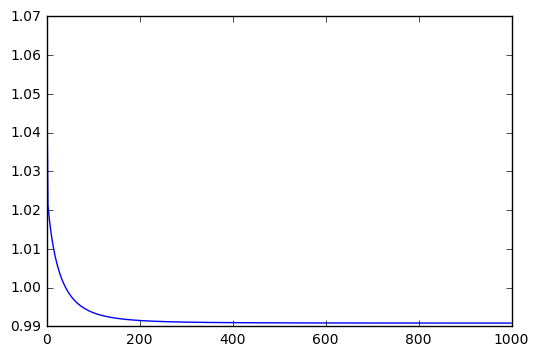

In [123]:
plt.plot(rmse_train[:1000])

In [109]:
rmse_train = np.append(rmse_train, np.zeros((1000,1)))

In [119]:
# Printing training rmse before any update loop
    
num_epochs

for it in range(89,1000): 
    
    print('Iteration No',it+1)
    # shuffle the training rating indices
    np.random.shuffle(nz_train)

    # decrease step size
    # gamma /= 1.2
    count = 0
    mat_pred = np.dot(item_features,user_features.T)
    begin = datetime.datetime.now()
    
    for d,n in nz_train:
                    
        difference = train[d,n] - mat_pred[d,n]
        
        # Updating the W
        
        gradient1 = -1* (difference) * user_features[n,:]
        item_features[d,:] = item_features[d,:]*(1 - gamma*lambda_item) - gamma * gradient1
        

        # Updating the Z
        
        gradient2 = -1* (difference) * item_features[d,:]
        user_features[n,:] = user_features[n,:]*(1 - gamma*lambda_user) - gamma * gradient2
        
            
    mat_pred = np.dot(item_features,user_features.T)
    
    #Calculating training rmse
    for i in range(len(nz_train)):
        real_train_label[i] = train[nz_train[i][0],nz_train[i][1]]
        prediction_train[i] = mat_pred[nz_train[i][0],nz_train[i][1]]
        
    rmse = calculate_mse(real_train_label, prediction_train) 
    rmse_train[it] = rmse
    
    print("iter: {}, RMSE on training set: {}.".format(it+1, rmse))
    end = datetime.datetime.now()
    execution_time = (end - begin).total_seconds()

    print('Iteration runtime: ',execution_time)
    if it < 3:
        go_up = 1.5
    if it >= 3:
        gamma = 0.00005
        go_up = 0.6
    gamma = gamma*go_up
    print(gamma,go_up)

Iteration No 90
iter: 90, RMSE on training set: 0.9941436387355326.
Iteration runtime:  24.158997
3e-05 0.6
Iteration No 91
iter: 91, RMSE on training set: 0.9940839703599273.
Iteration runtime:  27.003133
3e-05 0.6
Iteration No 92
iter: 92, RMSE on training set: 0.994025974719492.
Iteration runtime:  23.745511
3e-05 0.6
Iteration No 93
iter: 93, RMSE on training set: 0.993969453671326.
Iteration runtime:  25.417161
3e-05 0.6
Iteration No 94
iter: 94, RMSE on training set: 0.9939143034871564.
Iteration runtime:  25.373985
3e-05 0.6
Iteration No 95
iter: 95, RMSE on training set: 0.9938604542991801.
Iteration runtime:  25.905593
3e-05 0.6
Iteration No 96
iter: 96, RMSE on training set: 0.9938078537965751.
Iteration runtime:  23.770362
3e-05 0.6
Iteration No 97
iter: 97, RMSE on training set: 0.9937564612116546.
Iteration runtime:  25.447417
3e-05 0.6
Iteration No 98
iter: 98, RMSE on training set: 0.9937062337946435.
Iteration runtime:  21.123304
3e-05 0.6
Iteration No 99
iter: 99, RMSE